*See README.md for a brief definition of the project.*

*This serie is composed by three notebooks:*
 - *exploratory_analysis.ipynb;*
 - *pre_processing.ipynb; and*
 - *outlier_classification.ipynb (this one).*

 

# **Outlier Classification**
This is the third notebook of this series.


In this notebook, we will train the model built in the preprocessing phase (see notebook pre_processing.ipynb).

Besides, we will predict whether new work units are outliers or not. In order to do that, it will need to 
adapt the DBSCAN model used as the unsupervised clustering algorithm to perform predictions, since the sklearn implementation
doesn't provide one.

___
**IMPORTANT**:

The 3 notebooks are designed to be self-contained peaces of software, well suited for prototyping machine learning solutions.
Therefore, code shared among them is replicated in each one on purpose.
___


## Importing basic libraries

In [1]:
import os

import datetime
import os.path
import re
import sys
import time
import yaml
import traceback
import numpy as np 
from collections import defaultdict
from datetime import datetime
import glob
import matplotlib.pyplot as plt

import multiprocessing as mp

import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import pandas as pd

import joblib

## Auxiliary Classes

### Logging

In [2]:

from datetime import datetime

class log:

    def __print(msg="", label=None, date=True, newline=True, ret=False):

        msg_aux = "" 
        
        if date:
            str_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            msg_aux = msg_aux + f"<{str_time}> "
            
        if label is not None:
            str_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            msg_aux = msg_aux + f"[ {label} ] "
            
        msg_aux = msg_aux + f"{msg}"
        
        if newline:
            msg_aux = msg_aux + f"\n"

        print(f"{msg_aux}")
        
        if ret:
            return ret
        
    def line(newline=False, ret=False):
        log.__print(msg="---------------------------------------------------", date=False, newline=False)

    def printMessage(msg, newline=False):
        log.line()
        log.__print(msg=msg, newline=False)
        log.line()
        if newline:
            print("")
        
    def info(msg, ret=False):
        log.__print(label="INFO", msg=msg, ret=ret)
        
    def err(msg,ret=False):
        log.__print(label="ERROR", msg=msg,ret=ret)
        
    def warn(msg,ret=False):
        log.__print(label="WARN", msg=msg,ret=ret)
        
    def ok(ret=False):
        log.__print(label="OK", msg="",ret=ret)

### Utilities


In [3]:
class utl:
    
    def __make_pretty(styler):
        styler.set_caption("Statistics")
        #styler.format(rain_condition)
        #styler.format_index(lambda v: v.strftime("%A"))
        #styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
        styler.background_gradient(axis=None, vmin=0, vmax=10000, cmap="gray")
        return styler
    
    def view_statistics(describe):
        return describe.T.loc[:].style.pipe(utl.__make_pretty)
        







### Directory structure 

In [4]:

class Directories:
    
    SEP="/"
    
    def __init__(self, pandas_dirname=None, checkpoint_dirname=None, ambar_path=None, csv_dirname=None, dumps_dirname=None, models_dirname=None, verbose=False):
        self.pandas_dirname = pandas_dirname
        self.checkpoint_dirname = checkpoint_dirname
        self.ambar_path = ambar_path
        self.csv_dirname = csv_dirname
        self.dumps_dirname = dumps_dirname
        self.models_dirname = models_dirname
        self.verbose = verbose
        
    def __str__(self):
        ret = "[ INFO ] Main directories:\n" + str(self.__dict__)
        return ret

In [5]:

dirs = Directories( 
    ambar_path=None, 
    csv_dirname=None,
    dumps_dirname=None,
    pandas_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/datasets/pandas2/rtm/balancin/",
    checkpoint_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/",
    models_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/",
    )
log.info(str(dirs))
#rtm3d_azambuja_2023_07.pkl

<2023-07-07 14:42:09> [ INFO ] [ INFO ] Main directories:
{'pandas_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/datasets/pandas2/rtm/balancin/', 'checkpoint_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/', 'ambar_path': None, 'csv_dirname': None, 'dumps_dirname': None, 'models_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/', 'verbose': False}



## Preprocessing

### Preprocessing Pipeline

This implementation uses the sklearn Pipeline framework for representing the sequence of transformation over the dataset.

#### Data Copy

In [6]:

class Outplace(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        if v: log.printMessage("Making a copy from the original dataset...")
        X = X.copy()
        if v: log.printMessage("End")
        return X
    


#### Cleaning

In [7]:


class Cleanner_DropEmptyAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, describe=None, verbose=False):
        self.resume = describe
        self.verbose = verbose
    
    def __describe(self, X):
        if self.resume is None:
            if self.verbose:
                log.info("Calling describe() on original dataframe (may take long)...")
            self.resume = X.describe()
            if self.verbose:
                log.ok()
        else:
            if self.verbose:
                log.info("describe() ok! Nothing to be done!")
        return self.resume    
    
    def __select_column(self, column):
        discard = False
        # only zeros
        if column["min"] == 0 and column["max"] == 0:
            discard = True
        # same values
        elif column["min"] == column["max"]:
            discard = True
        return not discard
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        if self.resume is None:
            self.__describe(X)
            
        v = self.verbose    
        
        if v: log.printMessage("Cleanning: dropping empty attributes...")
        
        if v: log.info("Dropping attributes automatically...")
        cols2drop = list()
        for c in set(self.resume.columns): #iterate over numerical columns only
            if not self.__select_column(self.resume[c]):
                cols2drop.append(c)
        if len(cols2drop) > 1:
            if self.verbose:
                if v: log.warn(f"    {len(cols2drop)} attributes will be removed!")
            X.drop(columns=cols2drop, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X
    


In [8]:


class Cleanner_DropAttributesByExpert(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        
        if v: log.printMessage("Cleanning: dropping attributes by human decision (expert)...")
        
        if v: log.info("Dropping attributes by expert...")
        manual_drop_cols = ["workerid", "median", "file", "origin", \
            "refl_incx", "refl_incy", "refl_iprx", "refl_ipry", "refl_iulx", \
            "refl_iuly", "refl_z0", "refl_zf", "refl_zinc", "restr_eventos", \
            "tempo_checkpoint", "iprxe", "iprxs", "iprxv", "iprye", "iprys", \
            "ipryv", "iulxe", "iulxs", "iulxv", "iulye", "iulys", "iulyv", "nprocs",
            "node",
            "MEM", "PPG", # MEM has unexpected values. besides, the information is constant for the same cluster. PPG is redundant with ppg
            ]
        X.drop(columns=manual_drop_cols, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X
    

#pesos = "ppg", "mabx", "maby"



In [9]:


class Cleanner_DropRowsWithGarbage(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        if v: log.printMessage("Cleanning")
        
        if v: log.info("Dropping rows with only zeros...")
        X = X.loc[~(X == 0).all(axis=1)]
        if v: log.ok()
        
        if v: log.info("Dropping rows with missing values in most column...")
        X.drop(index=X[X["MEM"] == 0].index, inplace=True)
        if v: log.ok()
        
        if v: log.info("Dropping rows with beta and dev versions...")
        X.drop(index=X[X["versao"] == "Beta"].index, inplace=True)
        X.drop(index=X[X["versao"] == "DEV"].index, inplace=True)
        if v: log.ok()
        
        if v: log.info("Reseting indexes...")
        X.reset_index(drop=True, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X



In [10]:


class Cleanner_RenamingAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, describe=None, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        
        v = self.verbose    
        
        if v: log.printMessage("Cleanning: renaming some attributes for better meaning...")
        
        if v: log.info("Renaming column name from 'average' to 'y_estimated'...")
        X.rename(columns={'average': 'y_estimated'}, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X
    


#### Transforming

In [11]:


class Transformer_DataTypeConversion(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        
        v = self.verbose    
        
        if v: log.printMessage("Transformation: converting column data types...")
        
        if v: log.info("worktime attribute from timedelta64 to float64...")
        X['worktime'] = X['worktime'].dt.total_seconds().astype(np.float64)
        if v: log.ok()
        
        if v: log.info("Renaming column name from 'average' to 'y_estimated'...")
        X.rename(columns={'worktime': 'time_exec_sec'}, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X



In [12]:


class Transformer_BasicStringClustering(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        
        v = self.verbose    
        
        if v: log.printMessage("Transformation: clustering some categorical attributes...")
        
        if v: log.info("From node to machine name...")
        X['nodelist'] = X['nodelist'].str[:4]
        if v: log.ok()
        
        if v: log.info("From direm to file system name...")
        X['dirrem']  = X['dirrem'].str.partition('/')[2].str.partition('/')[0]
        if v: log.ok()
        
        if v: log.info("Renaming column name from 'nodelist' to 'machine_name'...")
        X.rename(columns={'nodelist': 'machine_name'}, inplace=True)
        if v: log.ok()
        
        if v: log.info("Renaming column name from 'dirrem' to 'fs_name'...")
        X.rename(columns={'dirrem': 'fs_name'}, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X



#### Filling Missing Values

In [13]:

class Filler(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        if v: log.printMessage("It is not necessary to worry about the missing values neither outliers.")
        return X
    


### Pipeline Wrappers


In [14]:


class CleannerPipe:
    def get_pipe(verbose=False):
        return Pipeline([
            ('cleanner 1', Cleanner_DropRowsWithGarbage(verbose=verbose)),
            ('cleanner 2', Cleanner_DropAttributesByExpert(verbose=verbose)), 
            ('cleanner 3', Cleanner_DropEmptyAttributes(verbose=verbose)),
            ('cleanner 4', Cleanner_RenamingAttributes(verbose=verbose)),
            ])


class FillerPipe:
    def get_pipe(verbose=False):
        return Pipeline([
            ('filler', Filler(verbose=verbose)),     # treat missing values
            ])


class TransformerPipe:
    def get_pipe(verbose=False):
        return Pipeline([
            ('string clustering', Transformer_BasicStringClustering(verbose=verbose)),
            ('data type conversion', Transformer_DataTypeConversion(verbose=verbose)),
            ])
        
    def get_pipe_with_onehot_encoding(features_to_encoding=None, other_features=None, verbose=False):
        
        assert features_to_encoding is not None, f"parameter features_to_encoding must be present"
        assert other_features is not None, f"parameter other_features must be present"
        
        return Pipeline([
            ('onehot', ColumnTransformer([
                ('onehot', OneHotEncoder(), features_to_encoding),
                ('numeric', 'passthrough', other_features),
                ])),
            ('scaler', MinMaxScaler(feature_range=(0, 1))),
            ])



class PreprocessingPipe:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.features_to_encoding = None
        self.other_features = None
        self.pipeline = None
        self.onehot_pipeline = None
    
    def __get_pipe(self):
        return Pipeline([
            ('outplace', Outplace(verbose=self.verbose)),               # make a copy of the original data
            ('cleanner', CleannerPipe.get_pipe(verbose=self.verbose)),  # clean data, remove outliers and rename columns
            ('filler', FillerPipe.get_pipe(verbose=self.verbose)),      # treat missing values
            ('transfomer', TransformerPipe.get_pipe(verbose=self.verbose)),     # treat missing values
            ])

    def __get_pipe_with_onehot_encoding(self):
        return Pipeline([
            ('outplace', Outplace(verbose=self.verbose)),               # make a copy of the original data
            ('transformer', TransformerPipe.get_pipe_with_onehot_encoding(features_to_encoding=self.features_to_encoding, other_features=self.other_features, verbose=self.verbose)),     # treat missing values
            ])
    
    def __get_other_features(self, X):
        other = list()
        for c in X.columns:
            if c not in self.features_to_encoding:
                other.append(c)
        return other

    def fit_transform(self, X):
        self.pipeline = self.__get_pipe()
        return self.pipeline.fit_transform(X)

    def onehot_fit_transform(self, X, features_to_encoding=None):
        self.features_to_encoding = features_to_encoding
        assert self.features_to_encoding is not None, f"parameter features_to_encoding must be present"
        
        self.other_features = self.__get_other_features(X)
        
        self.onehot_pipeline = self.__get_pipe_with_onehot_encoding()
        XX = self.onehot_pipeline.fit_transform(X)
        
        encoder = self.onehot_pipeline.named_steps['transformer'].named_steps['onehot'].named_transformers_['onehot']
        column_names = list(encoder.get_feature_names_out(self.features_to_encoding)) + self.other_features
        
        XX_df = pd.DataFrame(XX, columns=column_names)
        return XX_df



### Serialization

#### Pipeline Serialization

In [15]:
class PipelineSerializationBase:
    PIPE_NAME = "pipeline_preprocess.pkl"
    ONEHOT_PIPE_NAME = "pipeline_onehot_preprocess.pkl"
    
    def __init__(self, models_dir=None, verbose=False):
        self.models_dir = models_dir
        self.verbose = verbose

    def get_pipe_filename(self):
        return  self.models_dir + PipelineSerializationBase.PIPE_NAME
        
    def get_onehot_pipe_filename(self):
        return  self.models_dir + PipelineSerializationBase.ONEHOT_PIPE_NAME


class PipelineReader(PipelineSerializationBase):
    def __init__(self, models_dir=None, verbose=False):
        super().__init__(models_dir=models_dir, verbose=verbose)

    def __load(self, filename):
        if self.verbose:
            log.info(f"Loading pipeline from <{filename}>") 
        return joblib.load(filename)
        
    def load_pipe(self):
        filename = self.get_pipe_filename()
        return self.__load(filename)
    
    def load_onehot_pipe(self):
        filename = self.get_onehot_pipe_filename()
        return self.__load(filename)


### Structured Preprocessed Data Serialization
Reads the output of preprocessing phase.

In [16]:


class SerializationBase:
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        self.data = data
        self.checkpoint_dir = checkpoint_dir
        self.verbose = verbose



In [17]:


class PreprocessedDataSerializationBase(SerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        self.x_name = "X_preprocessed.pkl"

    def get_data_filename(self):
        return  self.checkpoint_dir + self.x_name


class PreprocessedDataReader(PreprocessedDataSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)

    def load(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Loading preprocessed data from <{filename}>") 
        self.data = joblib.load(filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to load: {end_time - start_time}')
        return self.data


class PreprocessedDataWriter(PreprocessedDataSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        
    def dump(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Dumping preprocessed data to <{filename}>") 
        joblib.dump(self.data, filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to dump: {end_time - start_time}')
    



In [18]:

class LabelSerializationBase(SerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        self.label_name = "Y_original.pkl"

    def get_data_filename(self):
        return  self.checkpoint_dir + self.label_name


class LabelReader(LabelSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)

    def load(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Loading preprocessed data from <{filename}>") 
        self.data = joblib.load(filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to load: {end_time - start_time}')
        return self.data


class LabelWriter(LabelSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        
    def dump(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Dumping preprocessed data to <{filename}>") 
        joblib.dump(self.data, filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to dump: {end_time - start_time}')
    



In [19]:
pre_reader = PreprocessedDataReader(checkpoint_dir=dirs.checkpoint_dirname, verbose=True)
X = pre_reader.load()

<2023-07-07 14:42:10> [ INFO ] Loading preprocessed data from </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/X_preprocessed.pkl>

<2023-07-07 14:42:15> [ INFO ] Time to load: 4.900522232055664



In [20]:
y_reader = LabelReader(checkpoint_dir=dirs.checkpoint_dirname, verbose=True)
Y = y_reader.load()

<2023-07-07 14:42:15> [ INFO ] Loading preprocessed data from </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/Y_original.pkl>

<2023-07-07 14:42:15> [ INFO ] Time to load: 0.12678050994873047



In [21]:
numeric_columns = list()
categorical_columns = list()
other_columns = list()
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        numeric_columns.append(c)
    elif pd.api.types.is_categorical_dtype(X[c]):
        categorical_columns.append(c)
    else:
        other_columns.append(c)
        
log.line()
log.info(f"Numerical attritutes (#{len(numeric_columns)}):")
print(numeric_columns)
log.line()
log.info(f"Other attritutes (#{len(other_columns)})")
print(other_columns)
log.line()
log.info(f"Categorical attritutes (#{len(categorical_columns)})")
print(categorical_columns)
log.line()



---------------------------------------------------
<2023-07-07 14:42:15> [ INFO ] Numerical attritutes (#78):

['machine_name_gr09', 'machine_name_gr10', 'machine_name_gr11', 'machine_name_gr12', 'fs_name_', 'fs_name_atlas', 'fs_name_dragao', 'fs_name_fenix', 'fs_name_fsgr09', 'fs_name_pegaso', 'versao_B3_0_9', 'versao_R1_8_1', 'versao_R1_8_3', 'versao_R1_8_4', 'versao_R2_0_0', 'versao_R2_0_2', 'versao_R3_0_4', 'versao_R3_0_6', 'versao_R3_1_1', 'versao_R3_1_2', 'versao_R3_1_3', 'versao_R3_1_4', 'versao_R3_1_5', 'versao_R3_2_0', 'versao_R3_2_1', 'versao_R3_2_10', 'versao_R3_2_11', 'versao_R3_2_12', 'versao_R3_2_13', 'versao_R3_2_2', 'versao_R3_2_3', 'versao_R3_2_4', 'versao_R3_2_6', 'versao_R3_2_8', 'versao_R3_2_9', 'abertx', 'aberty', 'angmax', 'comp_contrib', 'dt', 'dxsup', 'dysup', 'dz', 'freqmax', 'gathermax', 'gathermin', 'imagem', 'interpx', 'interpy', 'iorg_dado', 'mabx', 'maby', 'maxntrac', 'namost', 'nang', 'nfinline', 'ngather', 'nxe', 'nxtMax', 'nye', 'nytMax', 'nz', 'offmax

In [22]:
X_resume = X.describe()

In [23]:
utl.view_statistics(X_resume)

,count,mean,std,min,25%,50%,75%,max
machine_name_gr09,14737882.000000,0.154870,0.361780,0.000000,0.000000,0.000000,0.000000,1.000000
machine_name_gr10,14737882.000000,0.019650,0.138795,0.000000,0.000000,0.000000,0.000000,1.000000
machine_name_gr11,14737882.000000,0.433682,0.495582,0.000000,0.000000,0.000000,1.000000,1.000000
machine_name_gr12,14737882.000000,0.391798,0.488152,0.000000,0.000000,0.000000,1.000000,1.000000
fs_name_,14737882.000000,0.013624,0.115925,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_atlas,14737882.000000,0.014817,0.120819,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_dragao,14737882.000000,0.433679,0.495582,0.000000,0.000000,0.000000,1.000000,1.000000
fs_name_fenix,14737882.000000,0.143287,0.350365,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_fsgr09,14737882.000000,0.002796,0.052801,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_pegaso,14737882.000000,0.391798,0.488152,0.000000,0.000000,0.000000,1.000000,1.000000


In [24]:
Y_resume = Y.describe()

In [25]:
utl.view_statistics(Y_resume)

,count,mean,std,min,25%,50%,75%,max
y_estimated,14737882.000000,1001.251628,1464.859409,8.000000,271.736667,749.700000,1315.914634,42802.609375
y_std,14737882.000000,99.418438,613.208819,0.000000,1.708701,6.315930,14.657705,14561.173919


## Processing Pipeline

### Pipeline Wrappers


In [26]:

class ProcessingPipe:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.pipeline = None
    
    def fit(self, X):
        self.pipeline.fit(X)
    
    def predict(self, X):
        return self.pipeline.predict(X)


class DBSCANProcessingPipe(ProcessingPipe):
    def __init__(self, eps=0.1, min_samples=5, n_jobs=None, algorithm='auto', verbose=False):
        super().__init__(verbose=verbose)
        self.eps = eps
        self.min_samples = min_samples
        self.n_jobs = n_jobs
        self.algorithm=algorithm
        self.pipeline = self.__get_pipe()
    
    def __get_pipe(self):
        return Pipeline([
            ('clustering', DBSCAN(eps=self.eps, min_samples=self.min_samples, n_jobs=self.n_jobs)), 
            ])


class OPTICSProcessingPipe(ProcessingPipe):
    def __init__(self, xi=0.05, min_cluster_size=0.1, min_samples=5, algorithm='kd_tree', verbose=False):
        super().__init__(verbose=verbose)
        self.min_samples = min_samples
        self.xi = xi
        self.min_cluster_size = min_cluster_size
        self.algorithm = algorithm
        self.pipeline = self.__get_pipe()
    
    def __get_pipe(self):
        return Pipeline([
            ('clustering', OPTICS(min_samples=self.min_samples, xi=self.xi, min_cluster_size=self.min_cluster_size, algorithm=self.algorithm)), 
            ])


## Processing

### Parameter Estimators

In [42]:
class SimpleEpsEstimator:
    def run(n_dim=None, n_elem=None):
        assert n_dim is not None, f"dimensionality must be present"
        assert n_elem is not None, f"n_elem must be present"
        N_WORKS_FOR_JOB=10000
        return np.sqrt(n_dim) / N_WORKS_FOR_JOB
        #return np.sqrt(n_dim) / (n_elem/N_WORKS_FOR_JOB)


class KneeEpsEstimator:
    def __init__(self, algorithm='auto', verbose=False):
        self.verbose = verbose
        self.algorithm = algorithm
        self.k_distances = None
        self.distances = None
        self.k = None
        self.Xlen = None
        self.hiper_cube_diag = None
        
    def run(self, X=None, k=5):
        
        log.info(f"Running for k={k} and #dataset={len(X)}!")
        self.k = k
        self.Xlen = len(X)
        self.hiper_cube_diag = np.sqrt(len(X.columns))
        
        # Compute the k-distance graph
        start_time = time.time()
        knn = NearestNeighbors(n_neighbors=k, algorithm=self.algorithm)
        knn.fit(X)
        end_time = time.time()
        log.info(f"Time to build knn.fit: {end_time-start_time} secs")
        
        start_time = time.time()
        self.distances, _ = knn.kneighbors(X)
        self.k_distances = np.sort(self.distances[:, -1])
        print(self.distances.shape)
        end_time = time.time()
        log.info(f"Time to search for neighbhors: {end_time-start_time} secs")
        
    def show(self, xmin=0, xmax=None, ymin=0, ymax=None ):
        if xmax is None:
            xmax = self.Xlen
            
        if ymax is None:
            ymax = self.hiper_cube_diag
            
        # Plot the k-distance plot
        plt.plot(np.arange(len(self.k_distances)), self.k_distances)
        plt.xlabel('Points')
        plt.ylabel(f'{self.k}-Distance')
        plt.title('k-Distance Plot')
        delta_x = max(1,(xmax-xmin)/10)
        delta_y = max(0.01,(ymax-ymin)/10)
        print(delta_x)
        plt.xlim(xmin-delta_x, xmax+delta_x)
        plt.ylim(ymin-delta_y, ymax+delta_y)
        
        plt.show()


#### Visual Estimation

In [47]:

N=400000 # needed for performance issues
shuffle = np.arange(len(X), dtype=np.int64)
np.random.shuffle(shuffle)

eps_estimator = KneeEpsEstimator(verbose=True)#, algorithm='kd_tree')
eps_estimator.run(X=X.iloc[shuffle[:N]], k=30)


<2023-07-07 14:53:05> [ INFO ] Running for k=30 and #dataset=400000!

<2023-07-07 14:53:05> [ INFO ] Time to build knn.fit: 0.042975425720214844 secs

(400000, 30)
<2023-07-07 14:53:35> [ INFO ] Time to search for neighbhors: 30.028794288635254 secs



40000.0


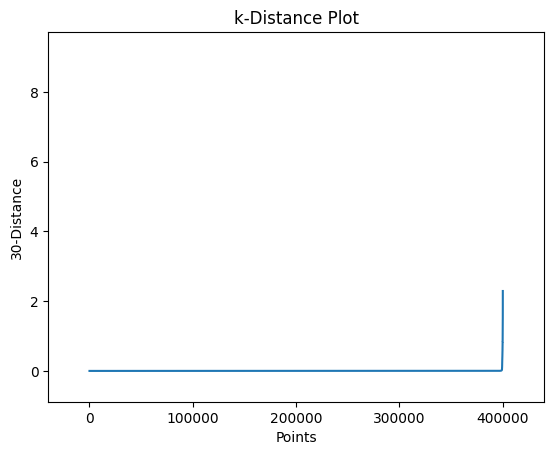

In [48]:

eps_estimator.show()

##### Zooming

120.0


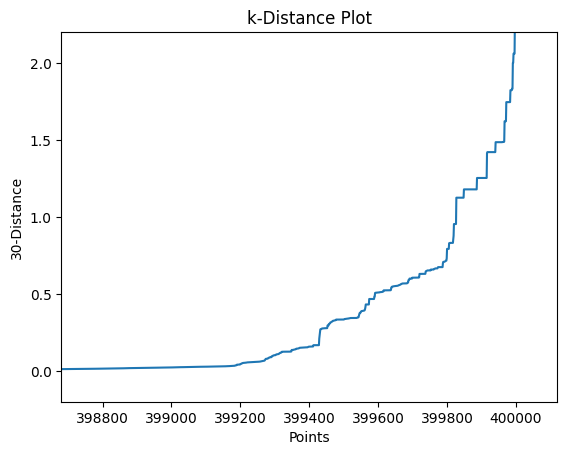

In [49]:
eps_estimator.show(xmin=398800, xmax=None, ymin=0, ymax=2)


35.0


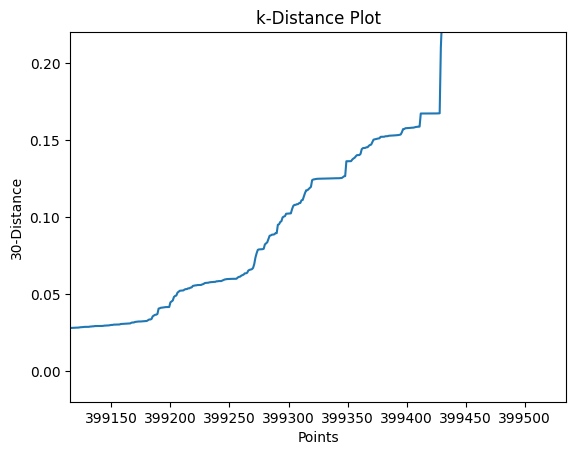

In [55]:
eps_estimator.show(xmin=399150, xmax=399500, ymin=0, ymax=0.2)


35.0


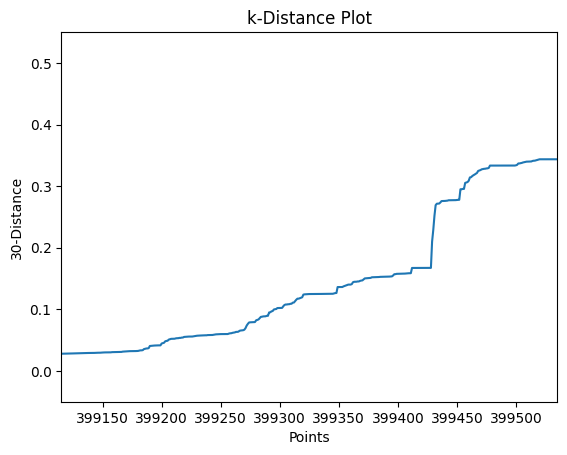

In [54]:
eps_estimator.show(xmin=399150, xmax=399500, ymin=0, ymax=0.5)


3.5


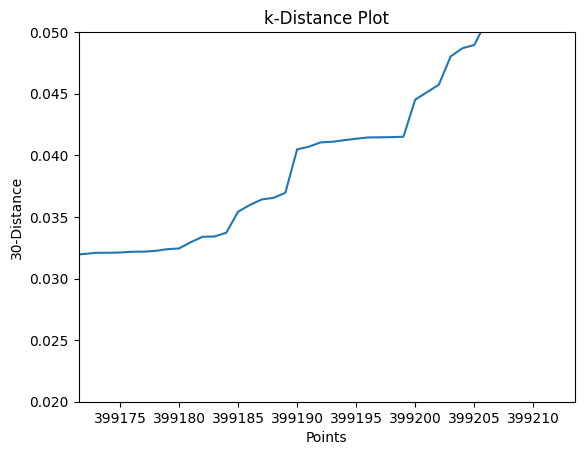

In [62]:
eps_estimator.show(xmin=399175, xmax=399210, ymin=0.03, ymax=0.04)


The k-distance plot with **k=30** shows the first relative change in the density of points occurs for **eps=0.0325** (the distance).

In [63]:
#eps = SimpleEpsEstimator.run(n_dim=len(X.columns), n_elem=len(X))
eps=0.0325 # from k-nn graph
k=30
log.info(f"DIMENSIONALITY = {len(X.columns)}")
log.info(f"EPS = {eps}")
log.info(f"K = {k}")
log.info(f"Hipercube diagonal = {np.sqrt(len(X.columns))}")


<2023-07-07 14:58:04> [ INFO ] DIMENSIONALITY = 78

<2023-07-07 14:58:04> [ INFO ] EPS = 0.0325

<2023-07-07 14:58:04> [ INFO ] K = 30

<2023-07-07 14:58:04> [ INFO ] Hipercube diagonal = 8.831760866327848



### Training

**IMPORTANT**:

DBSCAN algorithm is fast but could be very memory consuming. Empirical tests shown 400.000 points are near to the maximum possible in a machine with 1TB of RAM for the particular parameters chosen here.

#### Bootstrapping
Since we will have to train with less data, we need to:
 - choose a strategy for selecting a subset of points;
 - analyse models variance.

Bootstrapping technique seems suitable for this case. So we apply it
with random segmentation and replacement.  


In [65]:


NTRY=10
N=400000 # needed for performance issues
shuffle = np.arange(len(X), dtype=np.int64)

print(N)
for i in range(NTRY):
    log.info(f'[ {i} ]')
    np.random.shuffle(shuffle)
    start_time = time.time()
    proc_pipe_aux = DBSCANProcessingPipe(eps=eps, min_samples=k, n_jobs=1)  # empirical tests showed parallel isn't work (need more evaluation)
    proc_pipe_aux.fit(X.iloc[shuffle[:N]])
    end_time = time.time()
    dbscan = proc_pipe_aux.pipeline.named_steps['clustering']
    nclusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    noutliers = len(dbscan.labels_[dbscan.labels_ == -1])
    ratio = noutliers/N
    log.info(f"     [ {end_time - start_time} secs]  n_clusters = {nclusters}   -- n_outliers = {noutliers} / {ratio*100}%")
    
log.ok()

proc_pipe = DBSCANProcessingPipe(eps=eps, min_samples=k, n_jobs=1)  # empirical tests showed parallel isn't work (need more evaluation)
proc_pipe.fit(X.iloc[shuffle[:N]])



400000
<2023-07-08 03:16:28> [ INFO ] [ 0 ]

<2023-07-08 03:17:13> [ INFO ]      [ 44.32983589172363 secs]  n_clusters = 244   -- n_outliers = 748 / 0.187%

<2023-07-08 03:17:13> [ INFO ] [ 1 ]

<2023-07-08 03:17:58> [ INFO ]      [ 44.346864223480225 secs]  n_clusters = 247   -- n_outliers = 733 / 0.18325%

<2023-07-08 03:17:58> [ INFO ] [ 2 ]

<2023-07-08 03:18:43> [ INFO ]      [ 44.00416040420532 secs]  n_clusters = 247   -- n_outliers = 724 / 0.181%

<2023-07-08 03:18:43> [ INFO ] [ 3 ]

<2023-07-08 03:19:28> [ INFO ]      [ 44.236870527267456 secs]  n_clusters = 245   -- n_outliers = 798 / 0.19949999999999998%

<2023-07-08 03:19:28> [ INFO ] [ 4 ]

<2023-07-08 03:20:12> [ INFO ]      [ 44.031073331832886 secs]  n_clusters = 243   -- n_outliers = 818 / 0.2045%

<2023-07-08 03:20:12> [ INFO ] [ 5 ]

<2023-07-08 03:20:57> [ INFO ]      [ 43.76779222488403 secs]  n_clusters = 241   -- n_outliers = 864 / 0.216%

<2023-07-08 03:20:57> [ INFO ] [ 6 ]

<2023-07-08 03:21:42> [ INFO ]     

## Post Processing

###  Model Evaluation

This is a non-supervised problem. 

But, in production enviroment today, some statistical algorithms are being used 
for outlier classification. These algorithms aim to look for just one job execution at a time (a running execution).

So, we will compare our algorithm against the statistical ones mentioned above.


#### Building Labels from Production Strategy

##### Apply Denormalization First

In [66]:
# reading pipeline and getting scaler
reader_preproc_pipe = PipelineReader(models_dir=dirs.models_dirname, verbose=True)
prep_pipe = reader_preproc_pipe.load_onehot_pipe()


<2023-07-08 03:41:46> [ INFO ] Loading pipeline from </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/pipeline_onehot_preprocess.pkl>



In [68]:
scaler = prep_pipe.named_steps["transformer"].named_steps["scaler"]
min_value = scaler.data_min_[-1]
max_value = scaler.data_max_[-1]
time_exec_sec_norm = np.array(X["time_exec_sec"])
time_exec_sec_denorm = time_exec_sec_norm * (max_value - min_value) + min_value
log.info(f"time_exec_sec_denorm = {time_exec_sec_denorm}")


<2023-07-08 03:42:35> [ INFO ] time_exec_sec_denorm = [1969. 1906. 1905. ...  634.  759.  554.]



##### Mark Outliers From Production Current Strategy

**IMPORTANT**:

It seems there are a problem with the information given by the production module.
The provided information mark as outlier too many points. We still have to understand
why it is happening. Before we do this, the comparison between both solutions will not be possible.

In [70]:
assert len(Y) == len(X), f"X and Y must have the same size"

threshold = 0.2 # 10% from full job averaged
y_estimated_denorm = np.array(Y["y_estimated"])

assert len(y_estimated_denorm) == len(time_exec_sec_denorm), f"X and Y must have the same size"

#frac = np.abs(y_estimated_denorm - time_exec_sec_denorm) / y_estimated_denorm
frac = time_exec_sec_denorm / y_estimated_denorm

Y_outlier = np.full(len(frac), False)
for i,v in enumerate(frac):
    if v<(1-threshold) or v>(1+threshold):
        Y_outlier[i] = True
    #Y_outlier[i] = v>threshold
    
assert len(Y_outlier) == len(Y), f"Y_outlier and Y must have the same size"
log.info(f"Number of outliers given by production is: {len(Y_outlier[Y_outlier == True])}")


<2023-07-08 03:47:28> [ INFO ] Number of outliers given by production is: 3814968



#### Evaluate

##### Creating a predict function for DBSCAN

DBSCAN has no method predict. 

It is a non-supervised algorithm and sklearn didn't adapt 
the algorithm for further classification. 

In order to use the DBSCAN model to make predictions, we need to 
create a function to do that.


In [71]:
class DBSCAN_predict:
    def __init__(self, model=None, use_knn=False, verbose=False):
        self.verbose = verbose
        self.model = model
        self.knn = None
        if use_knn:
            if self.verbose:
                log.info(f"Creating NN structure with k = 1 and #core_points = {len(self.model.components_)}")
            self.knn = NearestNeighbors(n_neighbors=1, algorithm='auto')
            self.knn.fit(self.model.components_)
            log.ok()

    def __predict_brute_force(self, X):
        nr_samples = X.shape[0]
    
        y_new = np.ones(shape=nr_samples, dtype=int) * -1
    
        for i in range(nr_samples):
            if self.verbose:
                if i%(nr_samples//20) == 0:
                    log.info(f"[ {i} ]")
            diff = self.model.components_ - X[i, :]  # NumPy broadcasting
            #diff = self.model.components_ - list(X.iloc[i, :])            

            dist = np.linalg.norm(diff, axis=1)  # Euclidean distance
    
            shortest_dist_idx = np.argmin(dist)
    
            if dist[shortest_dist_idx] < self.model.eps:
                y_new[i] = self.model.labels_[self.model.core_sample_indices_[shortest_dist_idx]]
    
        return y_new
    
    def __predict_nn(self, X):
        y_new = np.ones(shape=X.shape[0], dtype=int) * -1
        dist, idx = self.knn.kneighbors(X)
        eps_valid_idx = [i for i,d in enumerate(dist) if d < self.model.eps]
        y_new[eps_valid_idx] = self.model.labels_[self.model.core_sample_indices_[idx[eps_valid_idx,0]]]
        return y_new
        
    def predict(self, X):
        if self.knn is None:
            return self.__predict_brute_force(np.array(X))
        else:
            return self.__predict_nn(np.array(X))
        
        

In [72]:
dbscan_predict = DBSCAN_predict(model=proc_pipe.pipeline.named_steps["clustering"], use_knn=True, verbose=True)


<2023-07-08 03:49:42> [ INFO ] Creating NN structure with k = 1 and #core_points = 399140

<2023-07-08 03:49:42> [ OK ] 



In [75]:

shuffle = np.arange(len(X), dtype=np.int64)
np.random.shuffle(shuffle)

N=-1#1500000
predicted_labels = dbscan_predict.predict(X.iloc[shuffle[:N]])
log.info(f"Number of predicted outlier is {len(predicted_labels[predicted_labels == -1])}")


<2023-07-08 04:11:16> [ INFO ] Number of predicted outlier is 30748



# Further Steps

Please, see README.md for more information about how to deploy this module in production.